<a href="https://colab.research.google.com/github/ryoungj/ObsScaling/blob/main/model_subset_selection_eval.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Model Subset Selection (Evaluation)

This notebook assesses the effectiveness of our model subset selection algorithm with holdout validation on the post-training analysis setup, corresponding to Sec 5 of the paper.

## Preparation

Colab specific setup: uncomment the following lines in colab

In [1]:
# ! git clone https://github.com/ryoungj/ObsScaling
# %cd ObsScaling
# ! pip install -r requirements.txt

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import re
import copy

from utils import *

In [3]:
%load_ext autoreload 
%autoreload 2
%config InlineBackend.figure_format = 'retina'

## Load Eval Data

Load benchmark eval results for base LLMs

In [4]:
base_llm_benchmark_eval = load_base_llm_benchmark_eval()

Load post-training eval results for base LLMs

In [5]:
eval_result_path = "./eval_results/base_llm_post_training_eval.csv"

post_training_eval = pd.read_csv(eval_result_path)

Merge eval results

In [6]:
base_llm_eval_with_post_training = pd.merge(base_llm_benchmark_eval, post_training_eval, on="Model")

## Evaluating Selection Method

### Setup

Setup arguments

In [7]:
# Cut off by FLOPs for holdout validation
CUTOFF_KWARGS = {
    "split_method": "cutoff_by_FLOPs (1E21)",
    "cutoff_threshold": 84,
}

# Setup kwargs
SCALING_SETUP_KWARGS = {
    # Data preprocessing: PCA imputation and extraction
    **NONGSM_PCA_PREPROCESS_KWARGS,  # exclude GSM to avoid making the task trivial, e.g., using GSM to predict GSM

    # Cutoff
    **CUTOFF_KWARGS,
    
    # Non-lineariy: sigmoid with parametrized scale and shift
    "nonlinearity": "sigmoid-parametric", 

    # Model families: include all we have evaled
    "df_filter": lambda x: x['Model Family'].isin(EVAL_BASE_MODEL_FAMILIES),   
    "df_groupby": 'Model Family',  # group markers by model family

    # Regression: ordinary least squares
    "reg_method": "robust",  
    "reg_kwargs": {"delta": 1.0},  # huber loss with delta=1.0 for normalized target within [0, 1] reduces to OLS
}

# Set the PCA nums to be 3 < the minimum 4 models. This is to avoid PCA error and has no effect on the results.
SCALING_SETUP_KWARGS["pca_kwargs"]["n_components"] = 3


Specify downstream metrics for analysis

In [8]:
GSM8K_METHOD_SCALING_COT_METRIC_MAP = {
    'gsm8k_5_exact_match,flexible-extract': "Naive + Greedy",
    'gsm8k_cot_8_exact_match,flexible-extract': "CoT + Greedy",
}

GSM8K_METHOD_SCALING_SELFCONS_METRIC_MAP = {
    'gsm8k_cot_self_consistency_8_exact_match,score-first-flexible-extract': "CoT + 1 Sample",
    'gsm8k_cot_self_consistency_8_exact_match,maj@5-flexible-extract': "CoT + SC + 5 Samples",
}

GSM8K_METHOD_SCALING_ORIG_METRIC_MAP = {
    **GSM8K_METHOD_SCALING_COT_METRIC_MAP,
    **GSM8K_METHOD_SCALING_SELFCONS_METRIC_MAP,
}

GSM8K_METHOD_SCALING_METRICS = [
    'gsm8k_5_exact_match,flexible-extract',
    'gsm8k_cot_8_exact_match,flexible-extract',
    # 'gsm8k_cot_self_consistency_8_exact_match,score-first-flexible-extract',
    'gsm8k_cot_self_consistency_8_exact_match,maj@5-flexible-extract',
]

GSM8K_SETUP_SPECIFIC_KWARGS = {}
for e in GSM8K_METHOD_SCALING_ORIG_METRIC_MAP.keys():
    GSM8K_SETUP_SPECIFIC_KWARGS[e] = {
        "plot_adjust_kwargs": {"title": GSM8K_METHOD_SCALING_ORIG_METRIC_MAP[e], "ylabel": "Accuracy"},
    }

    if e != "gsm8k_5_exact_match,flexible-extract":
        GSM8K_SETUP_SPECIFIC_KWARGS[e]["plot_adjust_kwargs"].update({"ylim": [-0.03, 0.97]})
    else:
        GSM8K_SETUP_SPECIFIC_KWARGS[e]["grace_range_ratios"] = [0.05, 0.15]

Specify model selection arguments

In [9]:
NUM_MODEL_BUDGETS = [4, 8, 12, 16, 20, 24, 28, 32, 36]

SELECTION_KWARGS = {
    "cutoff_kwargs": CUTOFF_KWARGS,
    "num_model_budgets": NUM_MODEL_BUDGETS,
    "max_family_to_search": 10,  # maximum number of model families to brute search
    "include_family": None,
    "exclude_models_with_na": True,  # exclude models with NA values in the PCA metrics here since they may have notable effects when the number of models is small
    "num_pc_for_select": 3,  # number of PCs to compute the variance for model selection
    "all_families_for_select": EVAL_BASE_MODEL_FAMILIES,  # all model families to consider for model selection
}

### Selecting model subsets

In [10]:
run_results, select_results = search_subset(
    base_llm_eval_with_post_training, 
    num_random_samples=5,  # get additional random model selections
    **SELECTION_KWARGS,
)

Total:  15913


15913it [00:14, 1104.68it/s]

>>> Num model budegt: 4

### Best configs:
 	 Object value: -26.76
 	 Model family (3): Phi, MPT, StarCoder2
 	 Models (4): microsoft/phi-2, microsoft/phi-1_5, mosaicml/mpt-7b, bigcode/starcoder2-3b


### Random configs:
 	 Object value: -39.90
 	 Model family (3): Gemma, Phi, StarCoder2
 	 Models (4): google/gemma-2b, microsoft/phi-2, microsoft/phi-1_5, bigcode/starcoder2-3b




>>> Num model budegt: 8

### Best configs:
 	 Object value: -8.84
 	 Model family (5): Llama-2, Llama, Phi, MPT, DeepSeek-Coder
 	 Models (8): meta-llama/Llama-2-7b-hf, huggyllama/llama-7b, huggyllama/llama-13b, microsoft/phi-2, microsoft/phi-1_5, mosaicml/mpt-7b, deepseek-ai/deepseek-coder-1.3b-base, deepseek-ai/deepseek-coder-6.7b-base


### Random configs:
 	 Object value: -22.76
 	 Model family (4): Gemma, Phi, StarCoder, StarCoder2
 	 Models (7): google/gemma-2b, microsoft/phi-2, microsoft/phi-1_5, bigcode/starcoderbase-1b, bigcode/starcoderbase-3b, bigcode/starcoderbase-7b, bigcode/starcoder2-3b




>>> 

### Scaling Predictions

Plot the scaling predictions with different number of models selected by our method

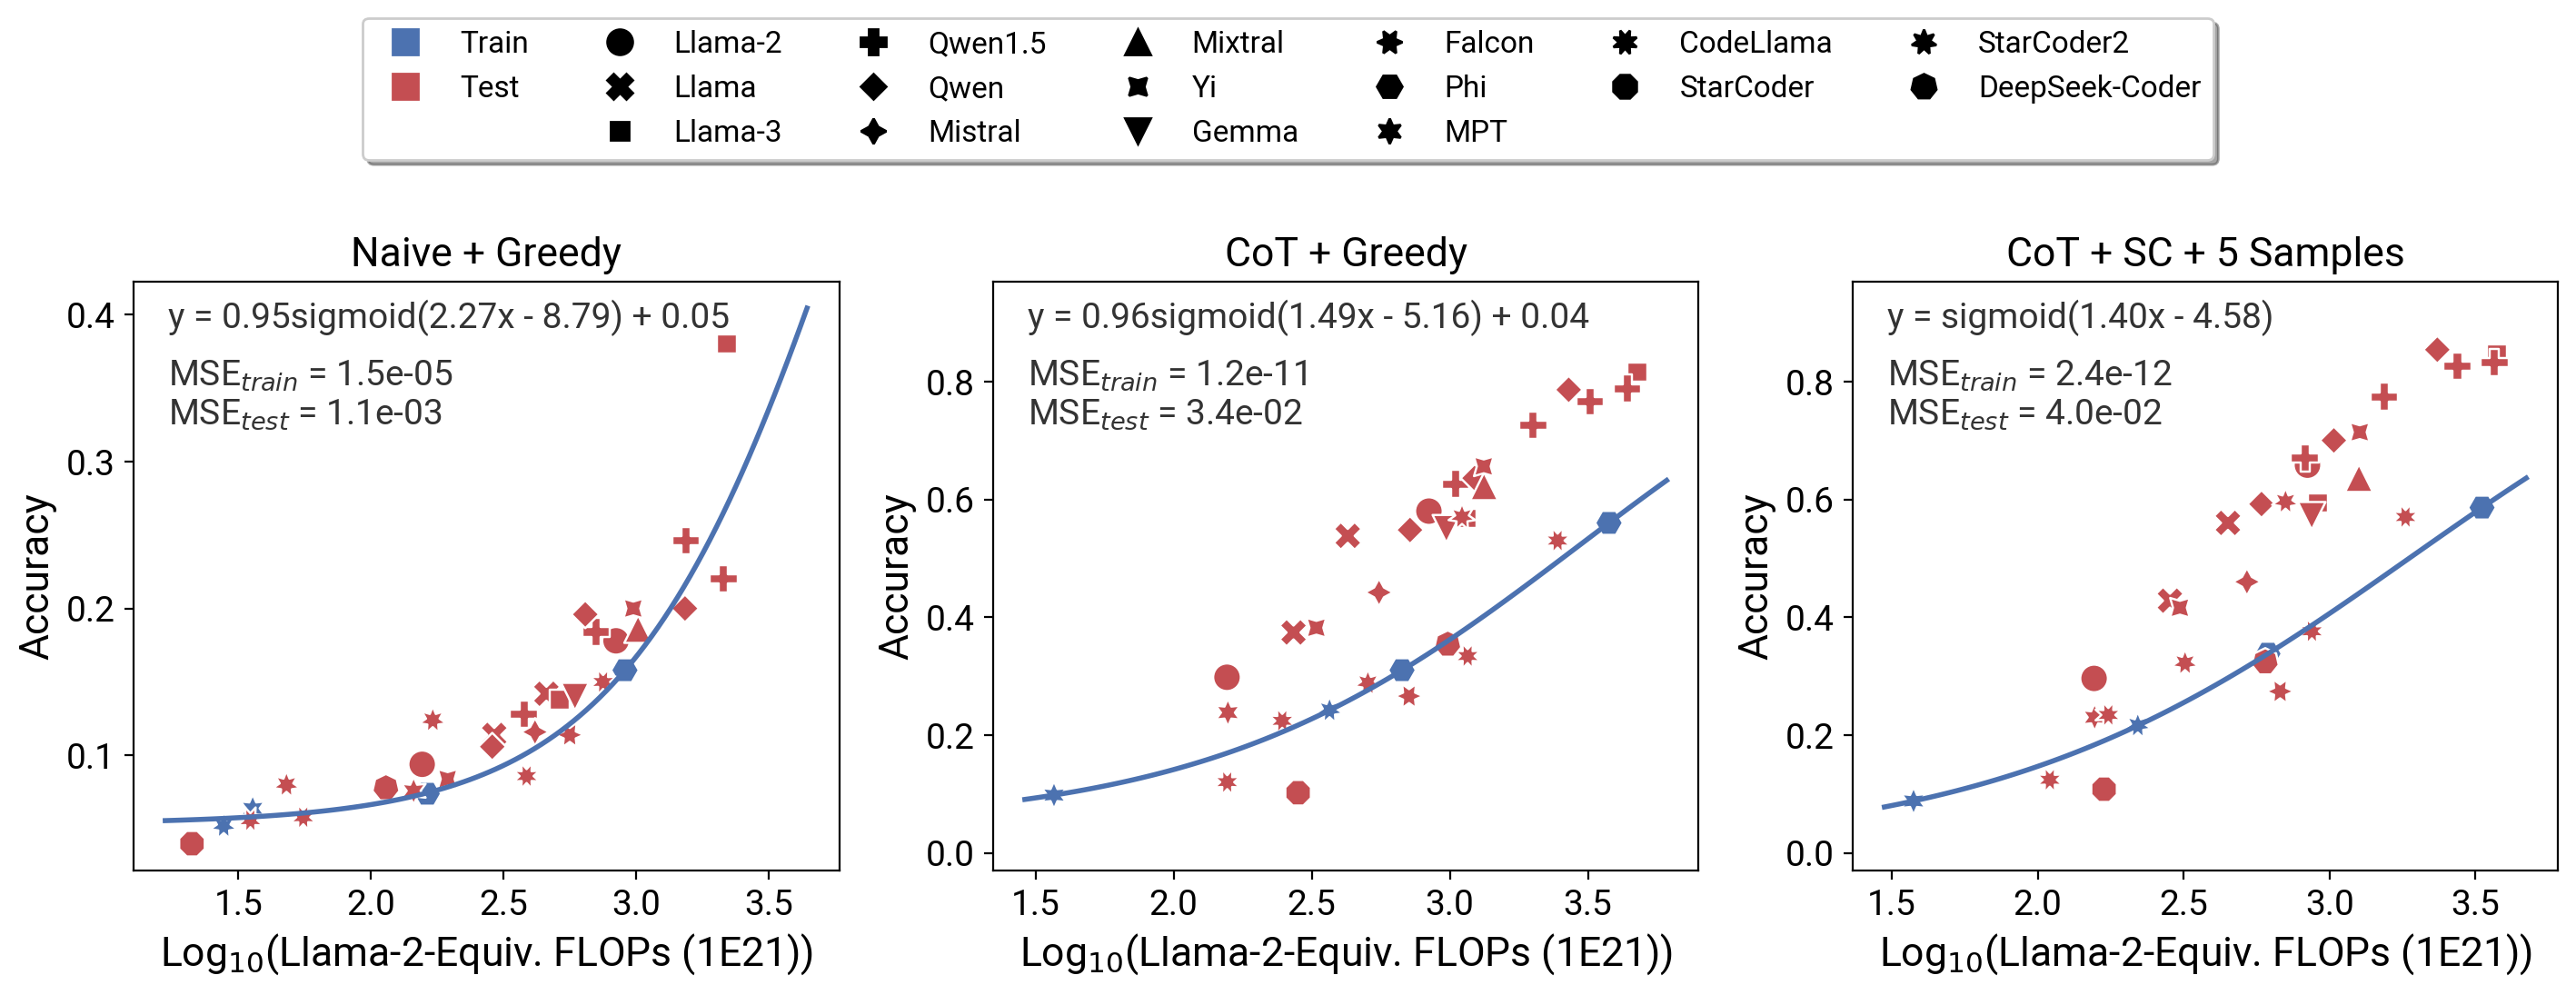

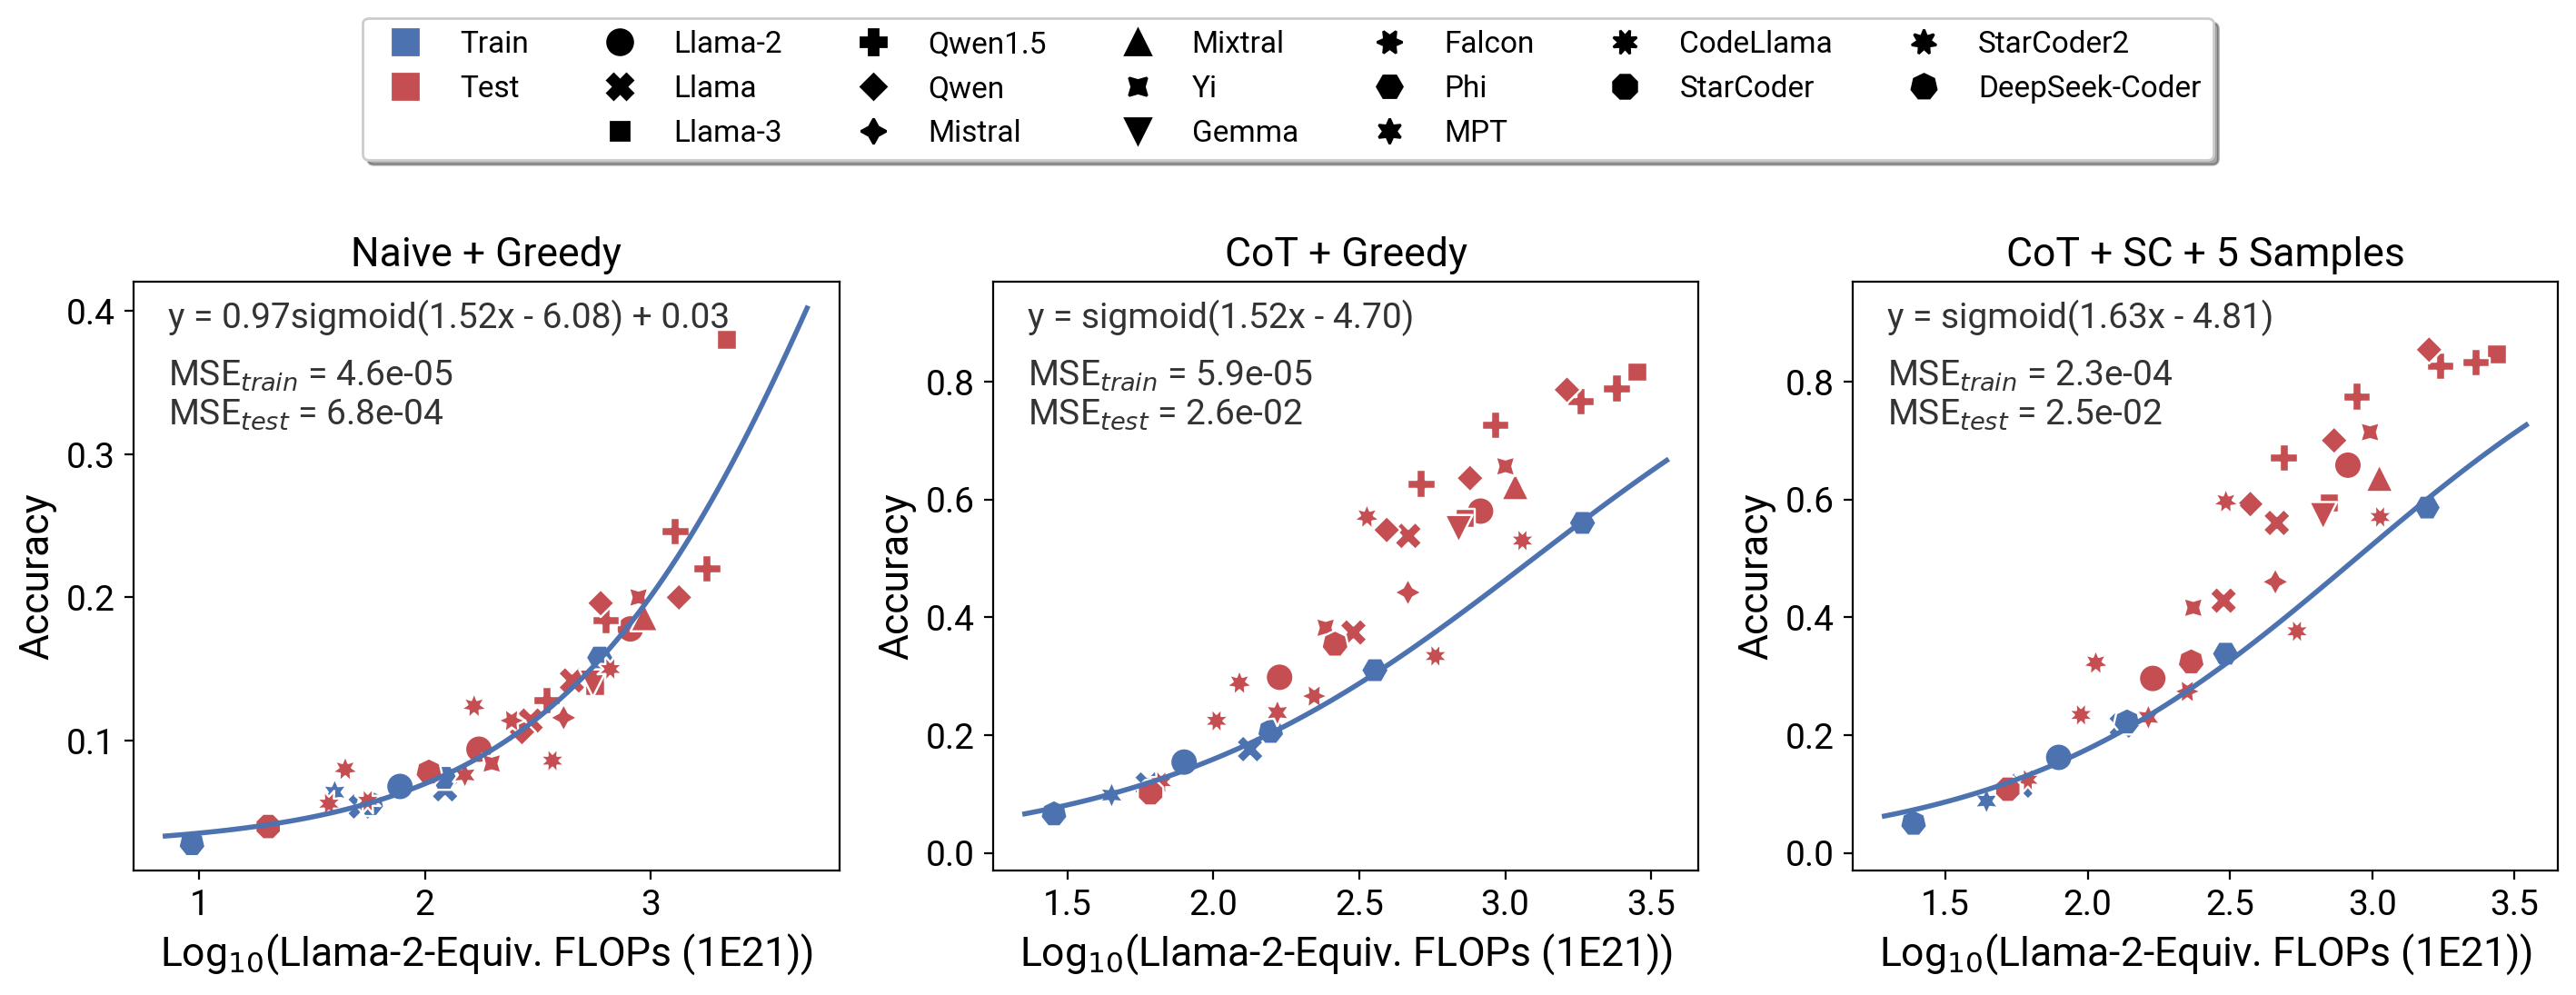

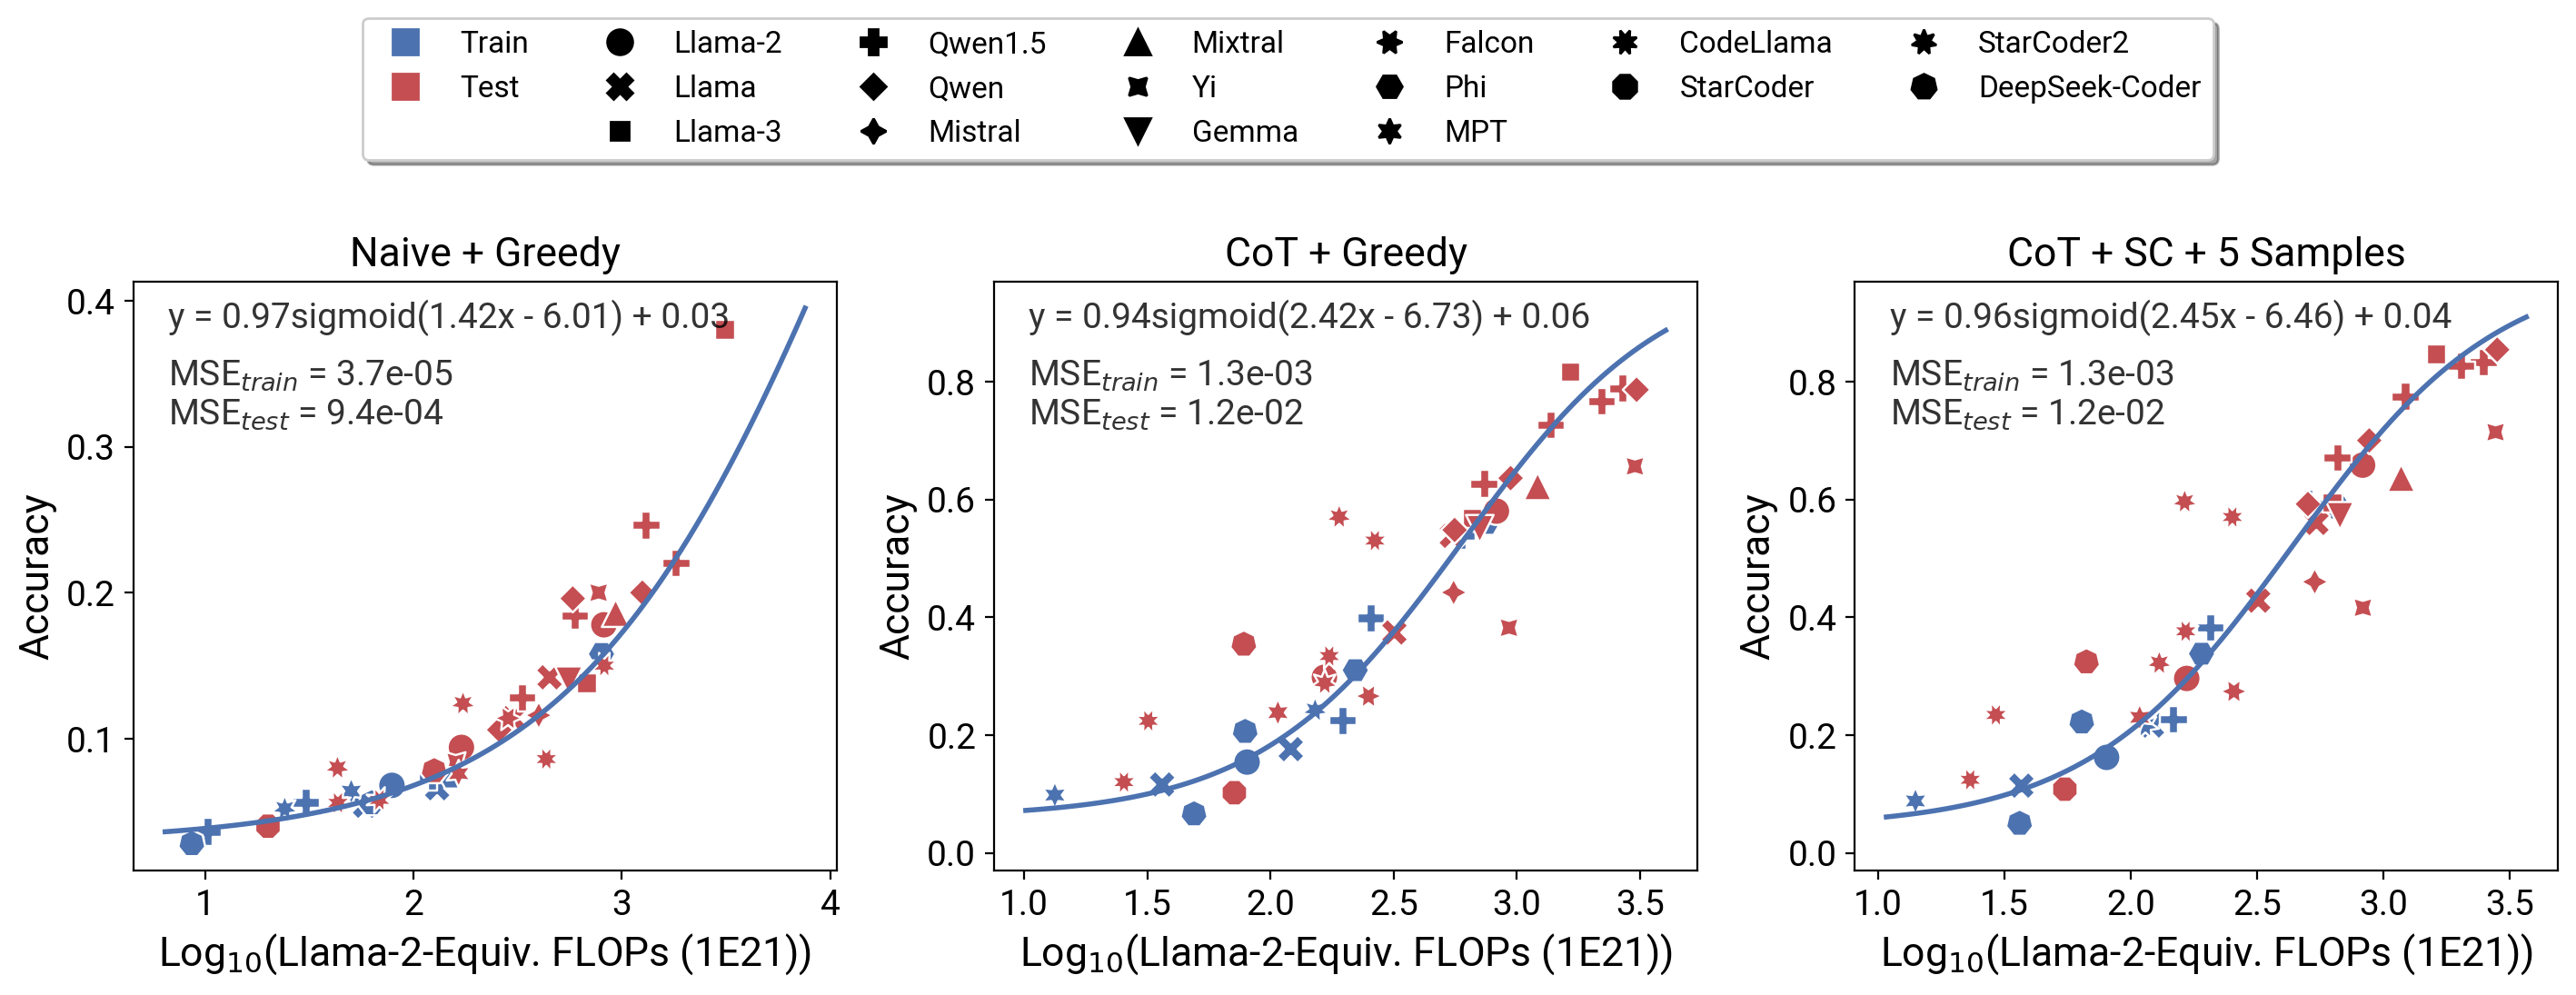

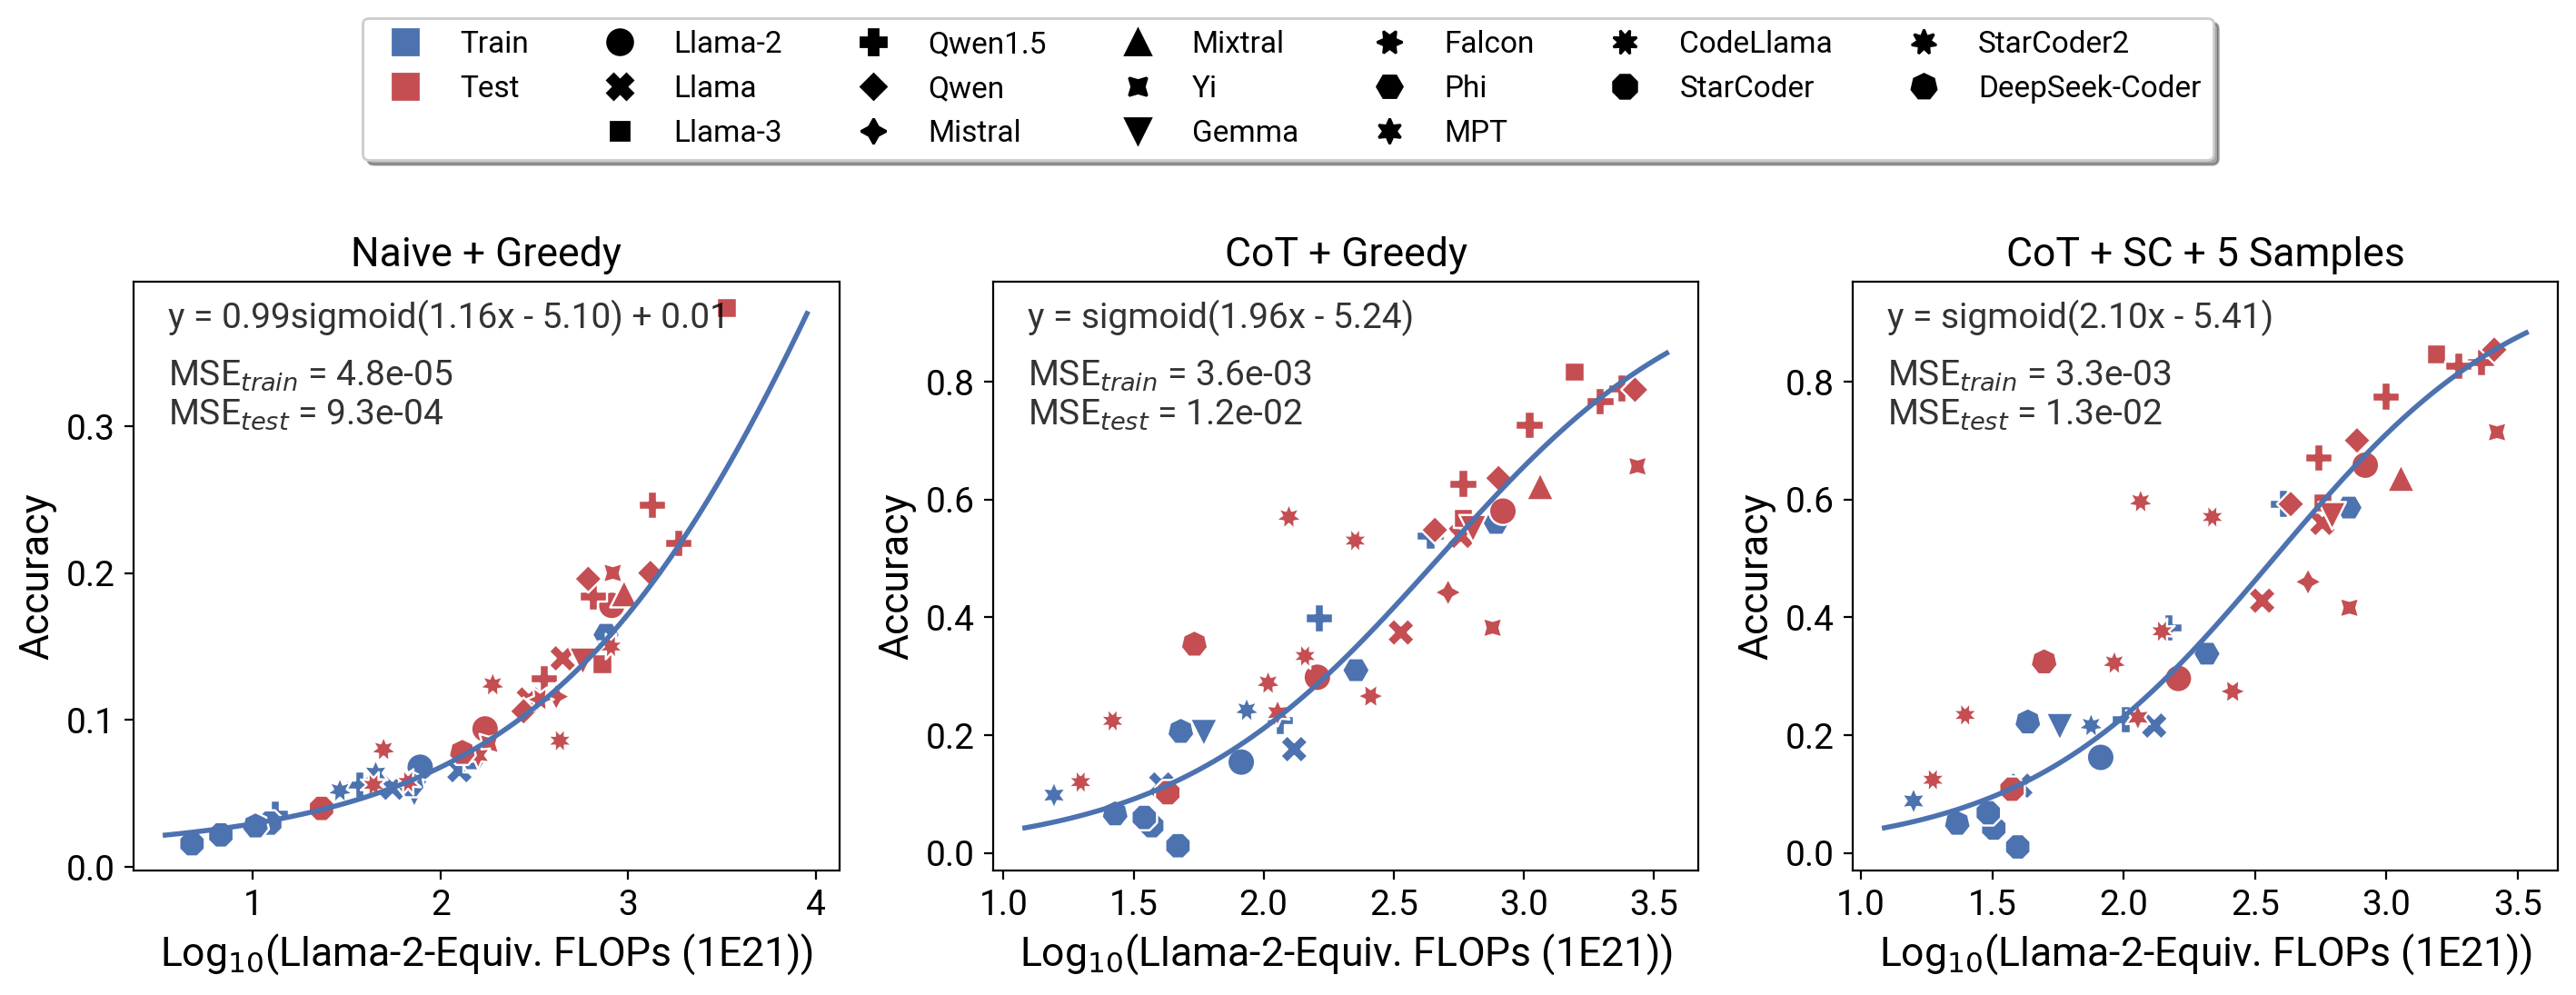

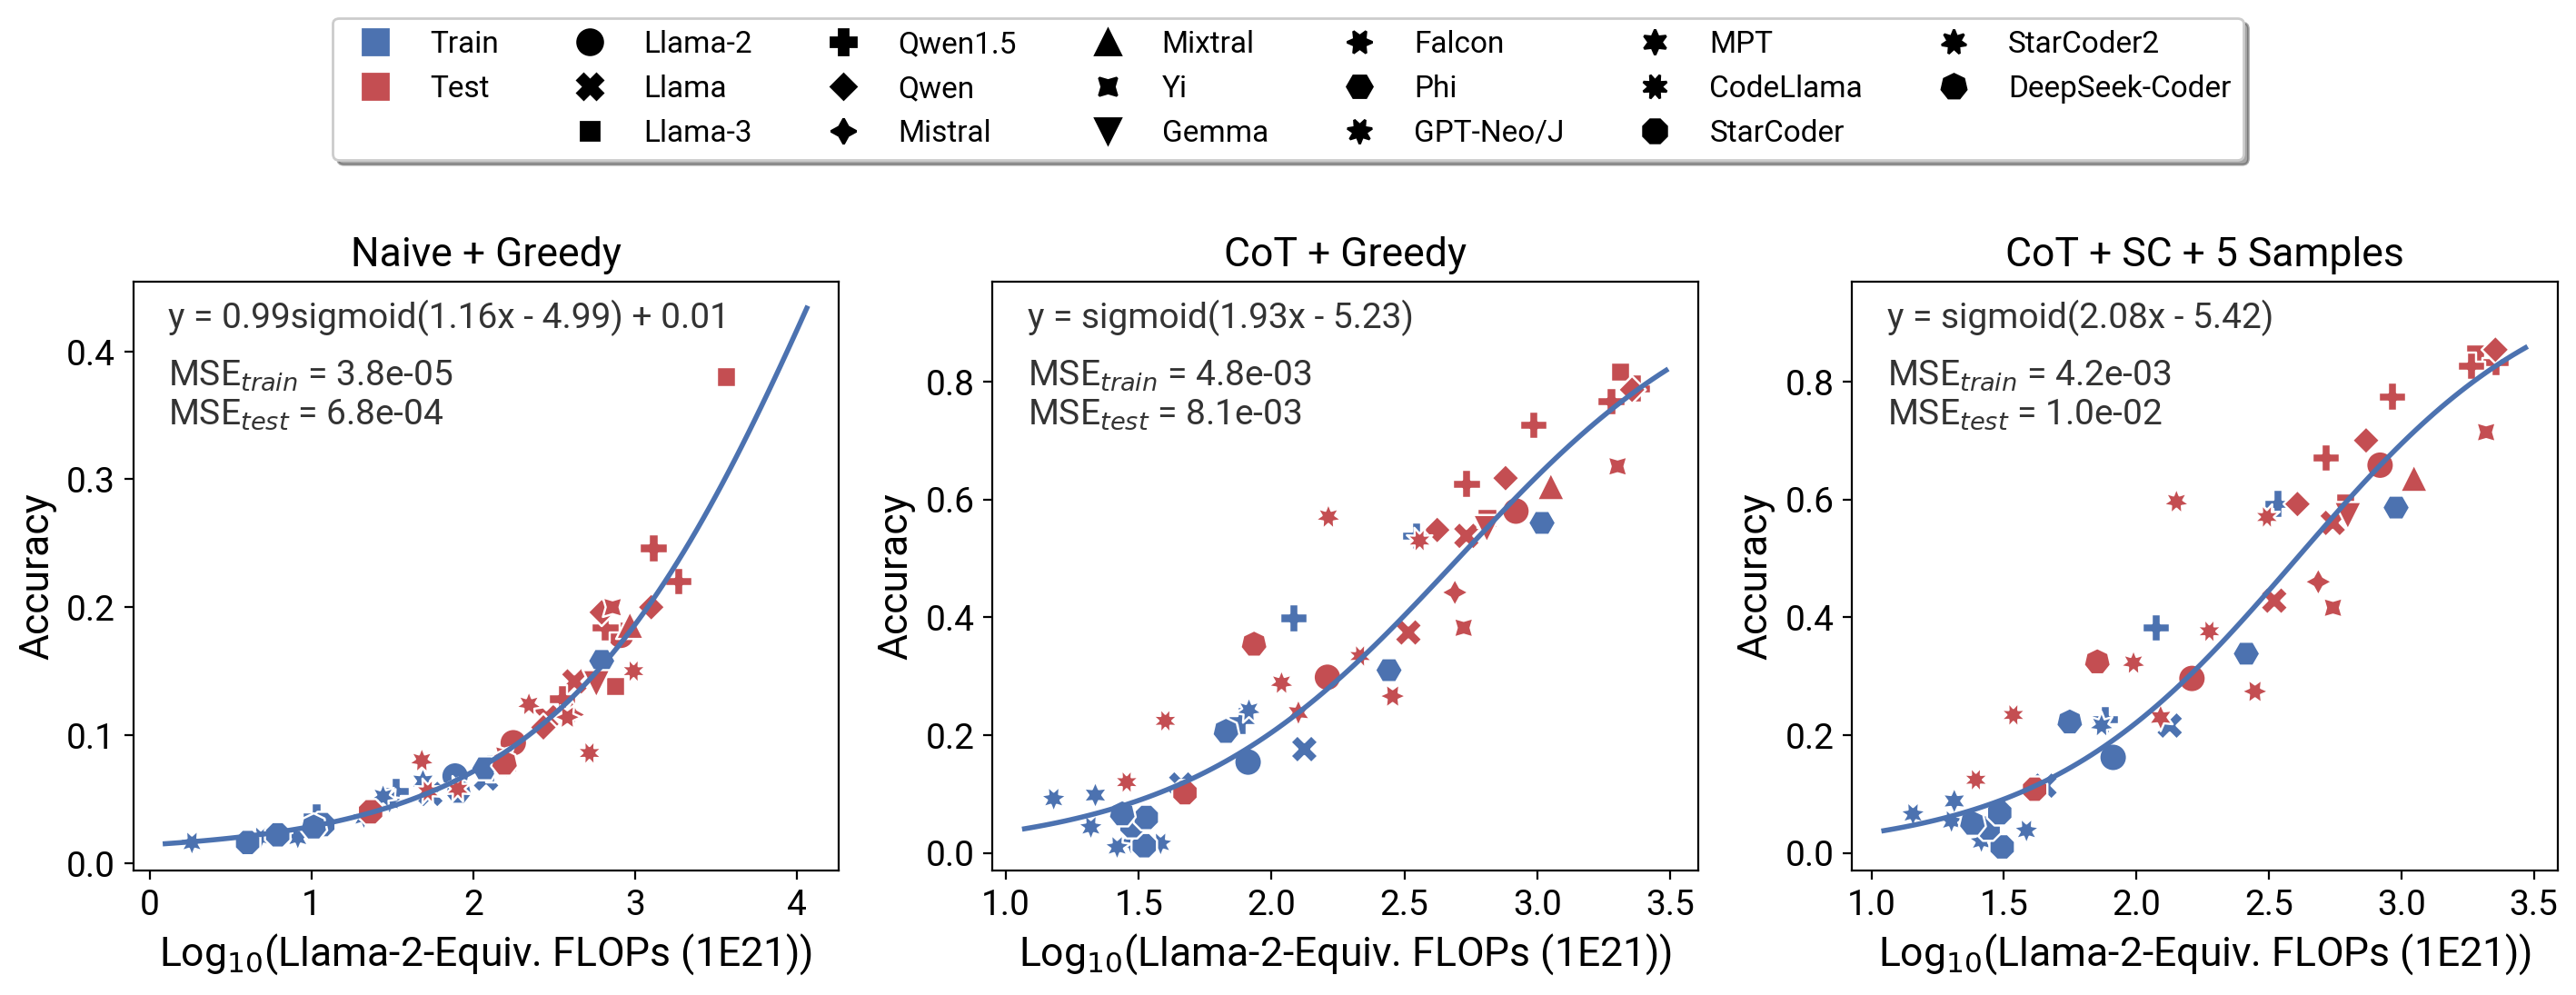

In [11]:
NUM_MODELS_TO_PLOTS = [4, 8, 12, 16, 20]

for num_model in NUM_MODELS_TO_PLOTS:
    analysis_setup_kwargs = {
        **SCALING_SETUP_KWARGS,
        **CUTOFF_KWARGS,

        # filter selected models
        "heldout_filter": select_results[str(num_model)]["best_heldout_filter"],
    }

    fig = plot_multi_scaling_predictions(
        base_llm_eval_with_post_training, GSM8K_METHOD_SCALING_METRICS, [PC_METRIC_NUM_3], analysis_setup_kwargs, 
        y_metric_specific_kwargs=GSM8K_SETUP_SPECIFIC_KWARGS,
        plot_legend=True, legend_nrow=3, legend_font_size=12, add_dummy_labels=1
    )

### Qualitative Comparison

Plot the average MSE vs num selected models for our selection method and random selection

In [12]:
from scipy.stats.mstats import gmean

selected_mse_array = []
random_mse_array = []
random_std_array = []
random_log_mse_array = []
random_log_std_array = []

plot_num_models = NUM_MODEL_BUDGETS

default_analysis_setup_kwargs = {
    **SCALING_SETUP_KWARGS,
    **CUTOFF_KWARGS,
}

def _compute_mean_mse(heldout_filter):

    analysis_setup_kwargs = {
        **default_analysis_setup_kwargs,
    }

    if heldout_filter is not None:
        analysis_setup_kwargs.update({
            # heldout filter
            "heldout_filter": heldout_filter,
        })

    mse_all = []

    for y_metric_name in GSM8K_METHOD_SCALING_METRICS:
        regress_metrics, _, _, _  = plot_scaling_predictions(
            base_llm_eval_with_post_training, PC_METRIC_NUM_3, y_metric_name, 
            compute_metrics_only=True,
            **analysis_setup_kwargs,
        )

        mse_all.append(regress_metrics["mse_test"])

    return gmean(mse_all)


for num_model in plot_num_models:
    best_mse = _compute_mean_mse(select_results[str(num_model)]["best_heldout_filter"])
    selected_mse_array.append(best_mse)

    _random_mse_all = []
    for idx in range(5):
        random_mse = _compute_mean_mse(select_results[str(num_model)][f"random_heldout_filter_idx_{idx}"])
        _random_mse_all.append(random_mse)

    random_mse_array.append(np.mean(_random_mse_all))
    random_std_array.append(np.std(_random_mse_all))
    random_log_mse_array.append(np.mean(np.log(_random_mse_all)))
    random_log_std_array.append(np.std(np.log(_random_mse_all)))


baseline_val = _compute_mean_mse(None)


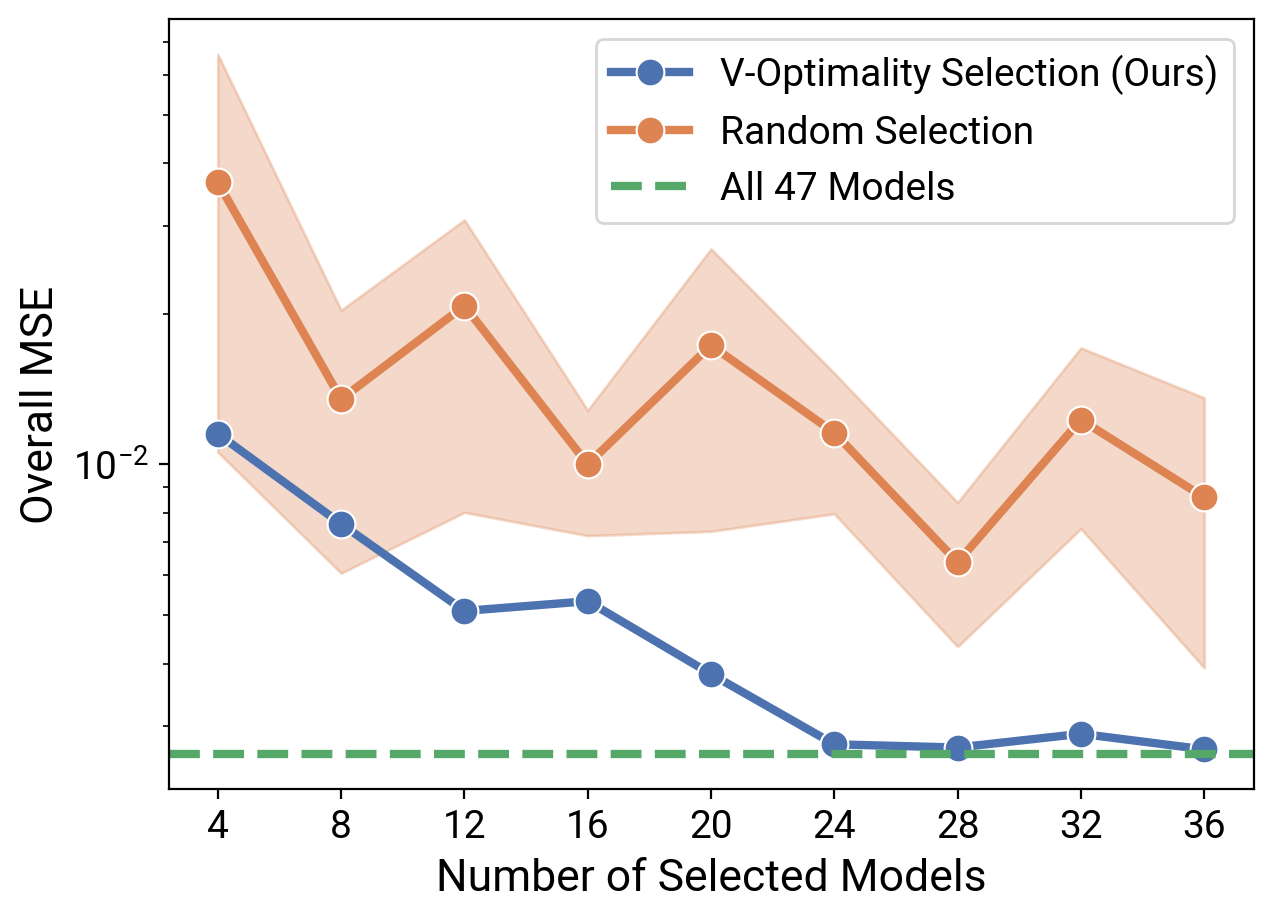

In [13]:
plt.figure(figsize=(7, 5))
ax = plt.gca()

color_palette = sns.color_palette()
sns.lineplot(x=plot_num_models, y=selected_mse_array, label='V-Optimality Selection (Ours)', ax=ax, color=color_palette[0], marker="o", markersize=10, linewidth=3)
sns.lineplot(x=plot_num_models, y=random_mse_array, label='Random Selection', ax=ax, color=color_palette[1], marker="o", markersize=10, linewidth=3)
ax.fill_between(plot_num_models, np.exp(np.array(random_log_mse_array) - np.array(random_log_std_array)), np.exp(np.array(random_log_mse_array) + np.array(random_log_std_array)), color=color_palette[1], alpha=0.3)
ax.axhline(y=baseline_val, color=color_palette[2], linestyle='--', label='All 47 Models', linewidth=3)
ax.set_xticks(plot_num_models)
ax.set_xlabel('Number of Selected Models')
ax.set_ylabel('Overall MSE')
ax.set_yscale("log")
ax.legend()